In [7]:
import numpy as np

In [8]:
import sys
sys.path.append("experiments/")

In [40]:
np.seterr(all="raise")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [9]:
from lib import Experiments

In [92]:
class FastGrad:
    def __init__(self, gamma, epsilon, n):
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n
        self.inf = 1e+6
        self.l = 1 / gamma

        self.a = self.alpha = 0
        
        self.u_lambda = self.u_mu = np.ones([n])
        self.y_lambda = self.y_mu = np.zeros(n)
        self.x_lambda = self.x_mu = np.ones([n])
        
        self.x_0 = np.ones([n, n]) / (n**2)

    
    def x_hat(self, c, lambda_y, mu_y):
        n = self.n
        a = np.min(self.gamma + c + lambda_y.repeat(n).reshape(-1, n) + mu_y.repeat(n).reshape(-1, n).T)
        expression = np.exp(
            -(self.gamma + c + lambda_y.repeat(n).reshape(-1, n) + mu_y.repeat(n).reshape(-1, n).T - a) / self.gamma
        )
        expression[expression < 1e-20] = 0
        x_hat = self.x_0 * expression
        return x_hat / x_hat.sum()
    
    def _new_alpha(self):
        return 1 / (2 * self.l) + np.sqrt(1 / (4 * (self.l**2)) + self.alpha**2)
    
    def _new_a(self, new_alpha):
        return self.a + new_alpha
    
    def _new_y(self, u_lambda, u_mu, x_lambda, x_mu):
        new_alpha = self._new_alpha()
        new_a = self._new_a(new_alpha)
        
        return (new_alpha * u_lambda + self.a * x_lambda) / new_a,\
               (new_alpha * u_mu     + self.a * x_mu)     / new_a
    
    def _new_u(self, c, u_lambda, u_mu, y_lambda_new, y_mu_new):
        x_hat = self.x_hat(c, y_lambda_new, y_mu_new)
        new_alpha = self._new_alpha()
        
        return u_lambda - new_alpha * (p - x_hat.sum(1)),\
               u_mu     - new_alpha * (q - x_hat.sum(0))
    
    def _new_x(self, u_lambda_new, u_mu_new, x_lambda, x_mu):
        new_alpha = self._new_alpha()
        new_a = self._new_a(new_alpha)
        
        return (new_alpha * u_lambda_new + self.a * x_lambda) / new_a,\
               (new_alpha * u_mu_new     + self.a * x_mu)     / new_a
    
    def f(self, c, x):
        return (c * x).sum() + self.gamma * ((x + 1e-16) * np.log((x + 1e-16) / self.x_0)).sum()
    
    def phi(self, c, p, q, lambda_x, mu_x):
        a = np.min(self.gamma + c + lambda_x.repeat(self.n).reshape(-1, self.n) + mu_x.repeat(self.n).reshape(-1, self.n).T)
        expression = np.exp(
                    -(self.gamma + c + lambda_x.repeat(self.n).reshape(-1, self.n) + mu_x.repeat(self.n).reshape(-1, self.n).T - a) / self.gamma
                )
        expression[expression < 1e-20] = 0.
        return -(lambda_x * p).sum() - (mu_x * q).sum() - \
                self.gamma * np.log(1/np.e * (self.x_0 * expression).sum())
    
    def deviation_p_q(self, x, p, q):
        return np.sqrt(np.sum((x.sum(1) - p)**2) + np.sum((x.sum(0) - q)**2))
    
    def fit(self, c, p, q):
        k = 0
        
        while True:
            y_lambda_new, y_mu_new = self._new_y(self.u_lambda, self.u_mu, self.x_lambda, self.x_mu)
            c = 1 / (2 * self.n) * (np.sum(y_mu_new) - np.sum(y_lambda_new))
            y_lambda_new += c
            y_mu_new -= c
            
            u_lambda_new, u_mu_new = self._new_u(c, self.u_lambda, self.u_mu, y_lambda_new, y_mu_new)
            x_lambda_new, x_mu_new = self._new_x(u_lambda_new, u_mu_new, self.x_lambda, self.x_mu)
            
            self.y_lambda, self.y_mu = (y_lambda_new, y_mu_new)
            self.u_lambda, self.u_mu = (u_lambda_new, u_mu_new)
            self.x_lambda, self.x_mu = (x_lambda_new, x_mu_new)
            
            self.alpha = self._new_alpha()
            self.a     = self._new_a(self.alpha)
            
            x_wave = self.x_hat(c, self.y_lambda, self.y_mu)
            r = np.sqrt((self.x_lambda**2).sum() + (self.x_mu**2).sum())
            epsilon_wave = self.epsilon / r
            
            
            criteria_a = self.deviation_p_q(x_wave, p, q) <= epsilon_wave
            criteria_b = self.f(c, x_wave) - self.phi(c, p, q, self.x_lambda, self.x_mu) <= self.epsilon
            
            if k % 100 == 0:
                print(f"{self.deviation_p_q(x_wave, p, q)}")
                print(f"{self.f(c, x_wave) - self.phi(c, p, q, self.x_lambda, self.x_mu)}\n")
            
            if criteria_a and criteria_b:
                return x_wave, k
            
            k += 1

In [93]:
n = 3
c = np.ones((n, n))
p = np.array([0.2, 0.3, 0.5])
q = np.array([0.5, 0.1, 0.3])

In [94]:
fgrad = FastGrad(0.05, 0.01, n)

In [95]:
fgrad.fit(c, p, q)

0.36055512754639896
1.827892062473289

0.057735026918991815
4.987925828979279

0.057735026918962554
14.048663023195001

0.057735026918962484
28.95759369669077

0.05773502691896256
49.70959471229469

0.05773502691896263
76.30220017756807

0.05773502691896255
108.73394803250395

0.05773502691896256
147.00386822991058

0.05773502691896268
191.1112693754248

0.05773502691896255
241.0556334462471

0.05773502691896256
296.8365577166175

0.057735026918962484
358.45372005705985

0.057735026918962484
425.9068569077071

0.05773502691896255
499.19574861704024

0.05773502691896255
578.3202093019647

0.05773502691896261
663.2800796096044

0.05773502691896268
754.0752214113833

0.05773502691896248
850.705513824505

0.05773502691896255
953.1708501699266

0.057735026918962484
1061.471135606444

0.057735026918962595
1175.606285262847

0.05773502691896258
1295.5762227435746

0.057735026918962644
1421.3808789189275

0.05773502691896258
1553.0201909351372

0.05773502691896258
1690.4941013965388

0.0577350

KeyboardInterrupt: 

In [56]:
def sample_batch(n):
    C = np.random.uniform(0, 10, size=[n, n])
    p = np.random.dirichlet(np.ones(n), size=1).ravel()
    q = np.random.dirichlet(np.ones(n), size=1).ravel()
    return C, p, q

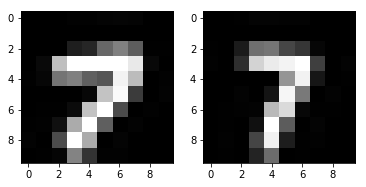

In [57]:
c, p, q = Experiments.load_data('experiments/test_data/1.png', 'experiments/test_data/2.png', show=True, size=10)
n = p.shape[0]